In [1]:
%matplotlib notebook
import numpy as np
from matplotlib import pyplot as plt
from pandas import DataFrame, Series, read_csv, to_datetime, concat

In [20]:
def remove_points(item):
    return ':'.join(item.split(':')[:-1:])


def parse_float(item):
    return float(item.split('=')[-1])


def clean_or_none(item, action):
    try:
        return action(item)
    except Exception as e:
        print(e)
        return None


def translate_datetime(data):
    data.time = [to_datetime('%s %s' % (date, time), format='%Y-%m-%d %H:%M:%S') for date, time in zip(data.date, data.time)]
    
    
def process_data(data):
    for i, row in data.iterrows():
        row.time = clean_or_none(row.time, lambda arg: ':'.join(arg.split(':')[:-1:]))
        row.time = to_datetime('%s %s' % (row.date, row.time), format='%Y-%m-%d %H:%M:%S')
        row.ip = clean_or_none(row.ip, lambda arg: arg.split(':')[0])
        row.ttl = clean_or_none(row.ttl, lambda arg: int(arg.split('=')[-1]))
        row.ping = clean_or_none(row.ping, lambda arg: float(arg.split('=')[-1]))
    return data.drop(columns=['date'])
        

data = read_csv('pinger_22012023.log', sep=' ', skiprows=[0], header=None)

data = data.drop(columns=[3, 4, 6, 9])
data.columns = ['date', 'time', 'bytes', 'ip', 'ttl', 'ping']

C:\Users\emb\AppData\Local\Temp\ipykernel_14660\4176822471.py:31: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  data = read_csv('pinger_22012023.log', sep=' ', skiprows=[0], header=None)


#%%timeit
mark_errors_none(data, 'time', lambda item: ':'.join(item.split(':')[:-1:]))
mark_errors_none(data, 'ip', lambda item: item.split(':')[0])
mark_errors_none(data, 'ttl', lambda item: int(item.split('=')[-1]))
mark_errors_none(data, 'ping', lambda item: item.split('=')[-1])

In [21]:
data = process_data(data)
data = data.dropna()

invalid literal for int() with base 10: 'Unreachable'
'float' object has no attribute 'split'
invalid literal for int() with base 10: 'of'
could not convert string to float: 'data.'


In [22]:
# clear anomalies
data = data.drop(data[data.ping > 1000].index)

In [23]:
from pandas import DatetimeIndex, Period
data.time = DatetimeIndex(data.time)

In [24]:
value_avg = lambda val: round(sum(val) / len(val), 2)
value_max = lambda val: max(val)
value_min = lambda val: min(val)

ping_by_hour = lambda row: (row.time.hour, row.ping)
ping_by_weekday = lambda row: (row.time.day_name(), row.ping)
ping_by_date_hour = lambda row: (row.time.strftime('%Y-%m-%d %H'), row.ping)

In [25]:
def get_statistics(data, by, resolver, calc):
    buff = {key: [] for key in by}
    
    for i, row in data.iterrows():
        key, val = resolver(row)
        try:
            buff[key].append(val)
        except Exception as e:
            print(key, val, buff[key])
        
    for key, val in buff.items():
        buff[key] = calc(0 if len(val) == 0 else val)
        
    return stat


def get_mma_stat(data, by, resolver, index_name='time'):
    buff = {key: [] for key in by}
    stat = {
        index_name: [],
        'min': [],
        'max': [],
        'avg': []
    }
    
    for i, row in data.iterrows():
        key, val = resolver(row)
        try:
            buff[key].append(val)
        except Exception as e:
            print(key, val, buff[key])
        
    for key, val in buff.items():
        stat[index_name].append(key)
        stat['min'].append(value_min(val))
        stat['max'].append(value_max(val))
        stat['avg'].append(value_avg(val))
        
    return DataFrame(stat)

In [26]:
weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
hours = [hour for hour in range(24)]
date_hours = [time for time in np.unique(data.time.dt.strftime('%Y-%m-%d %H'))]

def get_ping_hour_average(data):
    return get_statistics(data, hours, ping_by_hour, value_avg)


def get_ping_hour_max(data):
    return get_statistics(data, hours, ping_by_hour, value_max)


def get_ping_hour_min(data):
    return get_statistics(data, hours, ping_by_hour, value_min)


def get_ping_weekday_average(data):
    return get_statistics(data, weekdays, ping_by_weekday, value_avg)


def get_ping_weekday_max(data):
    return get_statistics(data, weekdays, ping_by_weekday, value_max)


def get_ping_weekday_min(data):
    return get_statistics(data, weekdays, ping_by_weekday, value_min)

In [27]:
ping_hour_stat = get_mma_stat(data, hours, ping_by_hour, index_name='hours')

In [28]:
ping_weekday_stat = get_mma_stat(data, weekdays, ping_by_weekday, index_name='day')

In [29]:
ping_date_hours_stat = get_mma_stat(data, date_hours, ping_by_date_hour)

In [30]:
ping_hour_stat

,hours,min,max,avg
0,0,9.54,80.4,11.42
1,1,9.56,58.2,11.42
2,2,9.59,81.3,11.43
3,3,9.59,106.0,11.37
4,4,9.50,77.3,11.27
5,5,9.51,75.4,11.26
6,6,9.55,107.0,11.20
7,7,9.57,93.3,11.13
8,8,9.54,45.5,11.12
9,9,9.58,40.4,11.16


In [31]:
ping_weekday_stat

,day,min,max,avg
0,Monday,9.91,106.0,11.30
1,Tuesday,9.69,130.0,11.34
2,Wednesday,10.20,88.3,11.32
3,Thursday,9.55,80.4,11.75
4,Friday,9.50,80.3,11.32
5,Saturday,10.30,104.0,11.39
6,Sunday,10.20,93.3,11.39


In [32]:
ping_date_hours_stat

,time,min,max,avg
0,2022-12-19 06,10.1,12.0,10.80
1,2022-12-19 07,10.1,15.4,10.71
2,2022-12-19 08,10.0,12.2,10.62
3,2022-12-19 09,10.1,17.3,10.80
4,2022-12-19 10,10.0,14.6,10.72
...,...,...,...,...
795,2023-01-21 18,10.3,17.0,11.35
796,2023-01-21 19,10.4,46.7,11.63
797,2023-01-21 20,10.5,15.0,11.61
798,2023-01-21 21,10.6,33.8,12.46


<IPython.core.display.Javascript object>


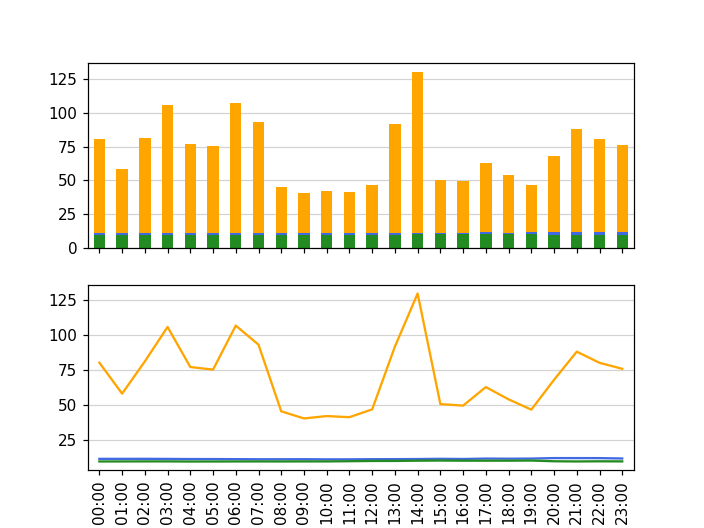

<IPython.core.display.Javascript object>


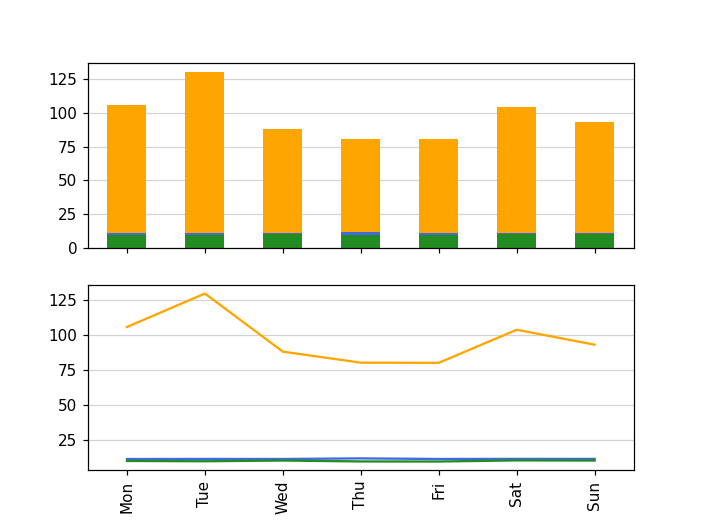

<IPython.core.display.Javascript object>


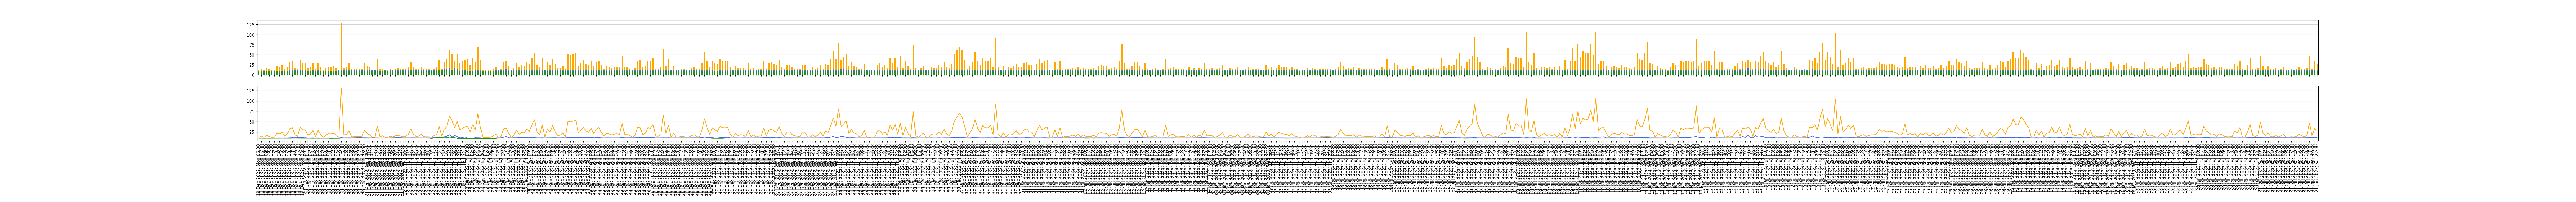

In [33]:
colors = {'min': 'forestgreen',
          'max': 'orange',
          'avg': 'royalblue',
          'grid': 'lightgray',
          'background': 'white'}

hours_labels = ['%s:00' % str(hour).rjust(2, '0') for hour in range(len(ping_hour_stat))]
weekdays_labels_en = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
weekdays_labels_ru = ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс']
date_hours_labels = [

    to_datetime(time).strftime('%d %b %Y, %a %H:%M') for time in date_hours
]
weekdays_labels = weekdays_labels_en

def make_pretty(ax):
    ax.grid(True, color=colors['grid'], axis='y')
    ax.figure.set_facecolor(colors['background'])
    ax.patch.set_alpha(0)
    ax.set_axisbelow(True)
    return ax
    
def plot_mma_bar(ax, data, labels, kind='bar'):
    data['max'].plot(ax=ax, kind=kind, color=colors['max'])
    ax.set_xticks(ticks=[], labels=[])
    
    data['avg'].plot(ax=ax, kind=kind, color=colors['avg'])
    ax.set_xticks(ticks=[], labels=[])
    
    data['min'].plot(ax=ax, kind=kind, color=colors['min'])
    ax.set_xticks(ticks=data.index, labels=labels, rotation='vertical')
    
    make_pretty(ax)
    
#     return make_pretty(ax)

fig_hours, (ax_hours_bar, ax_hours_line) = plt.subplots(nrows=2, sharex=True)
fig_weekdays, (ax_weekdays_bar, ax_weekdays_line) = plt.subplots(nrows=2, sharex=True)
fig_date_hours, (ax_date_hours_bar, ax_date_hours_line) = plt.subplots(nrows=2, sharex=True)

fig_date_hours.subplots_adjust(**{
    'top': 0.9,
    'bottom': 0.3,
    'left': 0.1,
    'right': 0.9
})

ax_date_hours_bar.sharex(ax_date_hours_bar)

plot_mma_bar(ax_hours_bar, ping_hour_stat, hours_labels, kind='bar')
plot_mma_bar(ax_weekdays_bar, ping_weekday_stat, weekdays_labels, kind='bar')
plot_mma_bar(ax_date_hours_bar, ping_date_hours_stat, date_hours_labels, kind='bar')

plot_mma_bar(ax_hours_line, ping_hour_stat, hours_labels, kind='line')
plot_mma_bar(ax_weekdays_line, ping_weekday_stat, weekdays_labels, kind='line')
plot_mma_bar(ax_date_hours_line, ping_date_hours_stat, date_hours_labels, kind='line')

In [16]:
time = to_datetime('2023-12-01 22:30')

In [17]:
dates = (date.strftime('%d.%m.%Y %H') for date in data.time.dt.date)
[date for date in dates]

['19.12.2022 00',
 '19.12.2022 00',
 '19.12.2022 00',
 '19.12.2022 00',
 '19.12.2022 00',
 '19.12.2022 00',
 '19.12.2022 00',
 '19.12.2022 00',
 '19.12.2022 00',
 '19.12.2022 00',
 '19.12.2022 00',
 '19.12.2022 00',
 '19.12.2022 00',
 '19.12.2022 00',
 '19.12.2022 00',
 '19.12.2022 00',
 '19.12.2022 00',
 '19.12.2022 00',
 '19.12.2022 00',
 '19.12.2022 00',
 '19.12.2022 00',
 '19.12.2022 00',
 '19.12.2022 00',
 '19.12.2022 00',
 '19.12.2022 00',
 '19.12.2022 00',
 '19.12.2022 00',
 '19.12.2022 00',
 '19.12.2022 00',
 '19.12.2022 00',
 '19.12.2022 00',
 '19.12.2022 00',
 '19.12.2022 00',
 '19.12.2022 00',
 '19.12.2022 00',
 '19.12.2022 00',
 '19.12.2022 00',
 '19.12.2022 00',
 '19.12.2022 00',
 '19.12.2022 00',
 '19.12.2022 00',
 '19.12.2022 00',
 '19.12.2022 00',
 '19.12.2022 00',
 '19.12.2022 00',
 '19.12.2022 00',
 '19.12.2022 00',
 '19.12.2022 00',
 '19.12.2022 00',
 '19.12.2022 00',
 '19.12.2022 00',
 '19.12.2022 00',
 '19.12.2022 00',
 '19.12.2022 00',
 '19.12.2022 00',
 '19.12.20

In [18]:
d = {i: {'min': i, 'max': i*10, 'avg': i*10} for i in range(11)}
df = DataFrame(d, columns=['min', 'max', 'avg'])

In [19]:
df

,min,max,avg
